# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [10]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_initial_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [11]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 2  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 20000 # Example number of data points
iterations_exp_initial = 1000 # Iterations for initial training phase
iterations_exp_long = 30000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers
#eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(x_points): # x_points is N x dim
    """
    Computes the target function psi(x) = ||x||_2^2 for the given problem.
    """
    return euclid_norm_sq(x_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)


# def invert_prior_lpn(x, model, INVERT_MODE):
#     y = invert(x,model,INVERT_MODE)
#     return y

# def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
#     try:
#         y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
#         psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
#     except NameError: 
#         print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
#         y_tensor = torch.from_numpy(y_inverted_points).float()
#         psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
#     prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
#     return prior_est


def evaluate_learned_J_HJ_approx(x_eval_points_np, model, t_val=1.0):
    """
    Evaluates the learned prior J_est(x) using the LPN and HJ approximation.
    J(x) ≈ S(x + t*grad_S(x,t), t) - (t/2)*||grad_S(x,t)||^2
    where S(x,t) = (1/2t)||x||^2 - (1/t)psi_t(x) if LPN learns psi_t(x).
    Here, LPN learns psi(x) which is psi_1(x), so we use t=1.
    S(x,1) = 0.5*||x||^2 - psi(x)
    grad_S(x,1) = x - grad_psi(x)
    
    Args:
        x_eval_points_np (np.ndarray): N x dim array of points to estimate J(x) at.
        model: The trained LPN model object (e.g., a torch.nn.Module).
        t_val (float): Time parameter, typically 1.0 for this setup.
    
    Returns:
        np.ndarray: N-dimensional array of estimated prior values J_est(x_eval_points).
    """
    x_tensor = torch.from_numpy(x_eval_points_np).float().to(device)
    x_tensor.requires_grad_(True)  # Ensure grad can be computed
    
    # grad_psi_x = nabla_psi(x)
    # The LPN's forward() method (model(x_tensor)) should return nabla_psi(x)
    grad_psi_x_tensor = model(x_tensor)
    
    # p_eval = nabla_S(x,1) = x - nabla_psi(x)
    p_eval_tensor = x_tensor - grad_psi_x_tensor
    
    # x_new = x + t * p_eval
    x_new_tensor = x_tensor + t_val * p_eval_tensor
    
    # psi_x_new = psi(x_new)
    psi_x_new_tensor = model.scalar(x_new_tensor)  # Should be N x 1
    
    # S(x_new, 1) = 0.5*||x_new||^2 - psi(x_new)
    norm_sq_x_new_tensor = torch.sum(x_new_tensor**2, dim=1, keepdim=True)  # N x 1
    S_x_new_t_tensor = 0.5 * norm_sq_x_new_tensor - psi_x_new_tensor  # N x 1
    
    # (t/2)*||p_eval||^2
    norm_sq_p_eval_tensor = torch.sum(p_eval_tensor**2, dim=1, keepdim=True)  # N x 1
    term2_tensor = (t_val / 2.0) * norm_sq_p_eval_tensor  # N x 1
    
    J_approx_tensor = S_x_new_t_tensor - term2_tensor  # N x 1
    
    return J_approx_tensor.detach().cpu().numpy().flatten()  # N-dimensional

def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_psi_true = x1_0_psi_true
        x2_0_J_true = x1_0_J_true

    x1_0_psi_est = cvx(x1_0_points, model)
    x1_0_J_est = evaluate_learned_J_HJ_approx(x1_0_points, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        x2_0_J_est = evaluate_learned_J_HJ_approx(x2_0_points, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\psi$ for $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"$\psi(x_1,0,...)$ - Dim {dim}, Concave Prior")
    plt.xlabel('$x_1$')
    plt.ylabel('$\psi(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\psi$ for $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"$\psi(0,x_2,0,...)$ - Dim {dim}, Concave Prior")
        plt.xlabel('$x_2$')
        plt.ylabel('$\psi(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned J)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, Concave Prior")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned J)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, Concave Prior")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [13]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Generate Training Data

In [14]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
x_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(x_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

x_j_exp_tensor = torch.from_numpy(x_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: x_j_exp_tensor shape {x_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")


--- Generating Training Data for Concave Quadratic Prior ---
Generated training data: x_j_exp_tensor shape torch.Size([20000, 2]), psi_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [15]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [16]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1000):
     single_iteration(i, data_points_exp, lpn_model_concave_quad, optimizer_concave_quad, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_concave_quad, optimizer_concave_quad, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---
iteration 0 loss 154.86769104003906
iteration 500 loss 0.33776161074638367
iteration 0 loss 0.13528479635715485
iteration 500 loss 0.0639406070113182
iteration 1000 loss 0.02984871156513691
iteration 1500 loss 0.014933908358216286
iteration 2000 loss 0.008339575491845608
iteration 2500 loss 0.0051253726705908775
iteration 3000 loss 0.00339810480363667
iteration 3500 loss 0.002370370551943779
iteration 4000 loss 0.0016930222045630217
iteration 4500 loss 0.0012276743073016405
iteration 5000 loss 0.0009148319950327277
iteration 5500 loss 0.0007096684421412647
iteration 6000 loss 0.0005698397872038186
iteration 6500 loss 0.000464252574602142
iteration 7000 loss 0.0003857232804875821
iteration 7500 loss 0.0025940556079149246
iteration 8000 loss 0.0002867142320610583
iteration 8500 loss 0.00025169868604280055
iteration 9000 loss 0.00021623654174618423
iteration 9500 loss 0.0001913322921609506
iteration 10000 loss 0.0001742761669

L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=2) ---


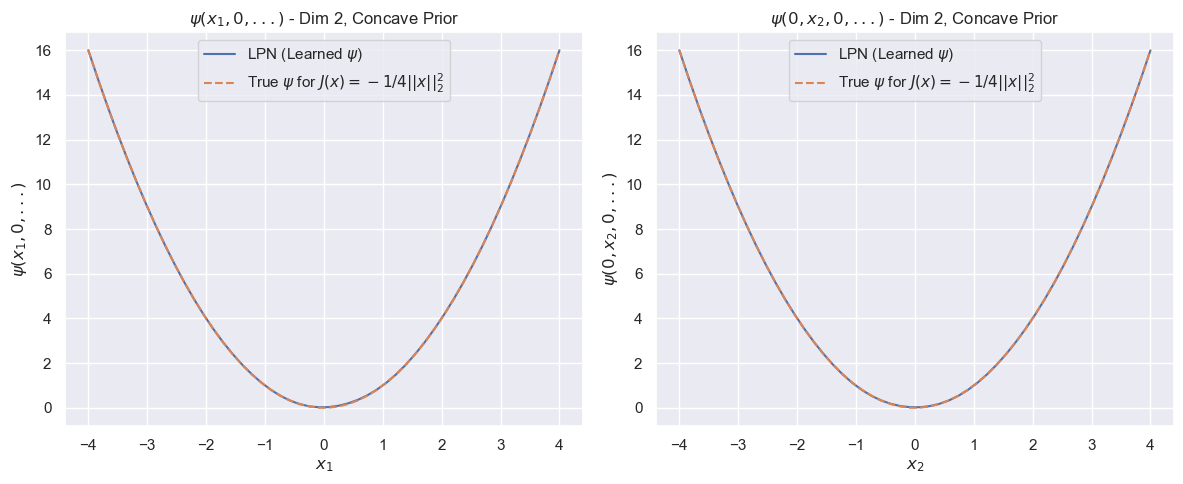

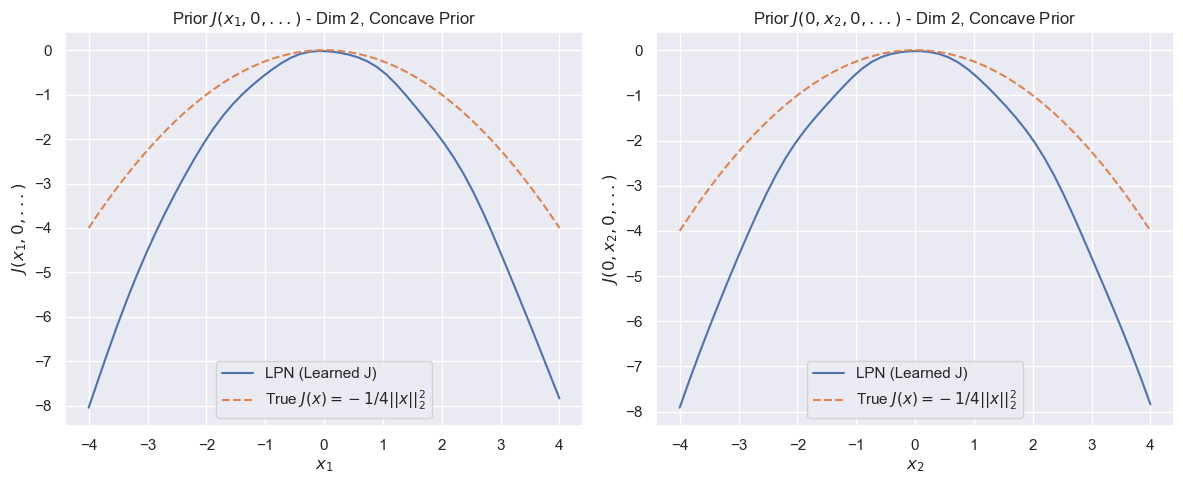

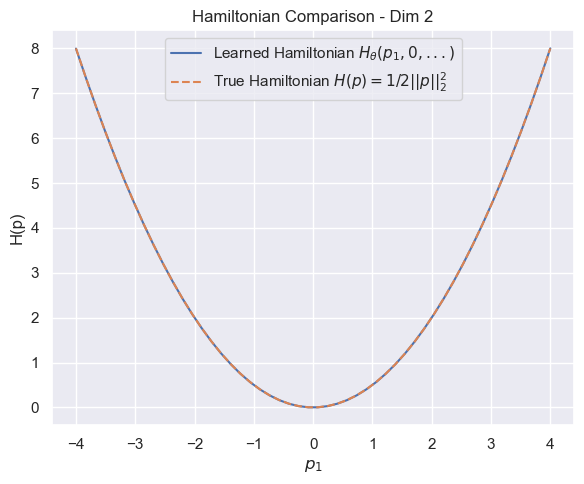

In [17]:
# --- Plot the results of the new experiment ---
plot_all_concave_quad(lpn_model_concave_quad, a_exp, spacing, INVERT_MODE, dim_exp)
evaluate_learned_H(lpn_model_concave_quad, a_exp, spacing, dim_exp)

L1 loss -- Train

In [ ]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad_l1 = torch.optim.Adam(lpn_model_concave_quad_l1.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1000):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=1, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad_l1.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=1, gamma_loss=None)

torch.save(lpn_model_concave_quad_l1.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l1.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---
iteration 0 loss 11.338580131530762
iteration 500 loss 0.3470780551433563
iteration 0 loss 0.10070376098155975
iteration 500 loss 0.032027821987867355
iteration 1000 loss 0.025934720411896706
iteration 1500 loss 0.022090613842010498
iteration 2000 loss 0.018883639946579933
iteration 2500 loss 0.01720612868666649
iteration 3000 loss 0.015401775948703289
iteration 3500 loss 0.015041198581457138
iteration 4000 loss 0.014026448130607605
iteration 4500 loss 0.0132414186373353
iteration 5000 loss 0.01266606617718935
iteration 5500 loss 0.01196219865232706
iteration 6000 loss 0.011487016454339027
iteration 6500 loss 0.010595058090984821
iteration 7000 loss 0.011118555441498756
iteration 7500 loss 0.010389224626123905
iteration 8000 loss 0.009962820447981358
iteration 8500 loss 0.009776663035154343
iteration 9000 loss 0.009501535445451736
iteration 9500 loss 0.009207180701196194
iteration 10000 loss 0.008836571127176285
iteration 

L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=16) ---


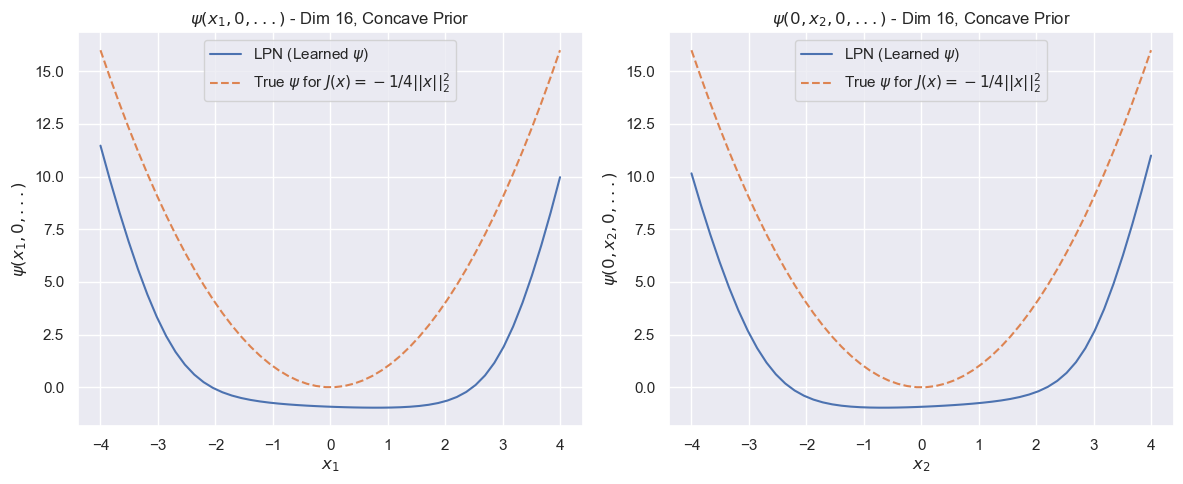

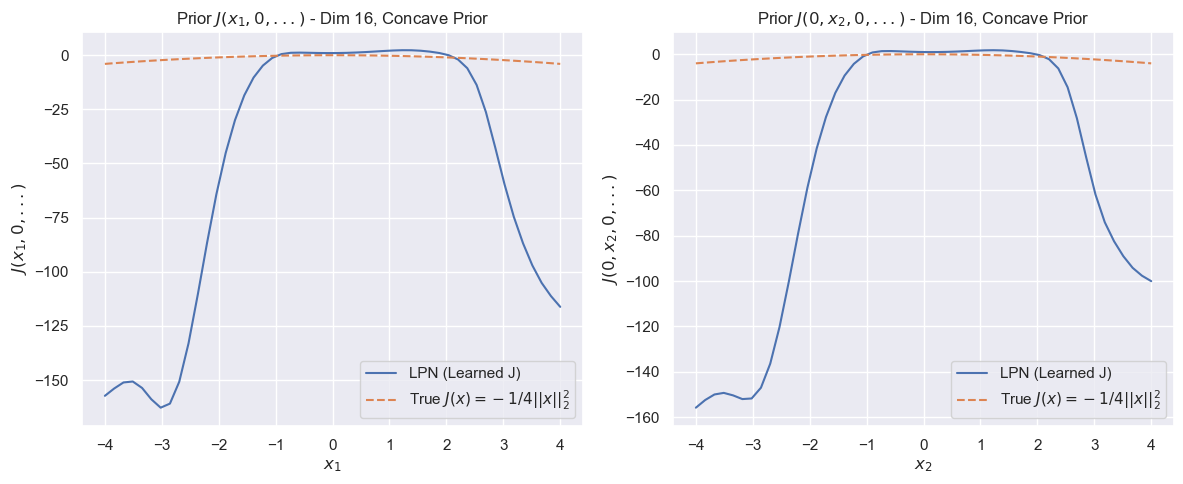

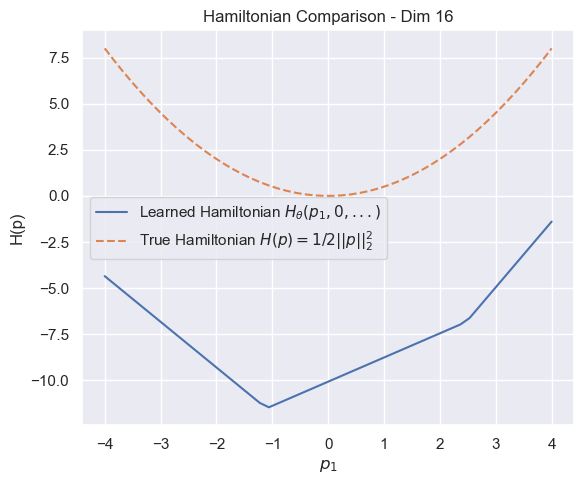

In [42]:
# --- Plot the results of the new experiment ---
plot_all_concave_quad(lpn_model_concave_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)
evaluate_learned_H(lpn_model_concave_quad_l1, a_exp, spacing, dim_exp)

Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [43]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 20

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 20 -- Plot

In [44]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 12.5 -- Train

In [45]:
# gamma_loss = 12.5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 12.5 -- Plot

In [46]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 10 -- Train

In [47]:
# gamma_loss = 10

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [48]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)